<a href="https://colab.research.google.com/github/mmmovania/CUDA_Spring2023/blob/main/Week4/RawImageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-kf1uvqt2
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-kf1uvqt2
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=de8eabdb2ba80ec360cf4362049e417e20ac07404e4aa4b542f14c0fe4306d46
  Stored in directory: /tmp/pip-ephem-wheel-cache-u1omr54t/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


In [2]:
#read image from our github repo
%cd /content
!wget -nc "https://github.com/mmmovania/CUDA_Spring2023/raw/main/images/Baboon.raw"

/content
--2023-01-28 09:42:57--  https://github.com/mmmovania/CUDA_Spring2023/raw/main/images/Baboon.raw
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mmmovania/CUDA_Spring2023/main/images/Baboon.raw [following]
--2023-01-28 09:42:58--  https://raw.githubusercontent.com/mmmovania/CUDA_Spring2023/main/images/Baboon.raw
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262144 (256K) [image/panasonic-raw]
Saving to: ‘Baboon.raw’

Baboon.raw          100%[===================>] 256.00K  --.-KB/s    in 0.01s   

2023-01-28 09:42:58 (22.0 MB/s) - ‘Baboon.raw’ saved [262144/262144]



In [3]:
%%cu
#include <stdio.h>
#include <cuda.h>

const int WIDTH = 512;
const int HEIGHT = 512;
const int SIZE = WIDTH*HEIGHT;
const int IMAGE_SIZE_IN_BYTES = SIZE * sizeof(unsigned char);

void load_raw_image(const char* imageName, unsigned char* pData)
{
	FILE* fp = fopen(imageName, "rb");
	if (fp)
	{
		fread(pData, 1, SIZE, fp);
		fclose(fp);
	}
	else
	{
		puts("Cannot open raw image.");
	}
}

void save_raw_image(const char* imageName, unsigned char* pData)
{
	FILE* fp = fopen(imageName, "wb");
	if (fp)
	{
		fwrite(pData, 1, SIZE, fp);
		fclose(fp);
	}
	else
	{
		puts("Cannot write raw image.");
	}
}

__global__ void PictureKernel(unsigned char* d_Pin,
	unsigned char* d_Pout,
	int n, int m, float brightness = 1) {
	//Calculate the row # 
	int Row = blockIdx.y*blockDim.y + threadIdx.y;

	//Calculate the column # 
	int Col = blockIdx.x*blockDim.x + threadIdx.x;

	if ((Row < m) && (Col < n)) {
		int offset = (Row*n) + Col;
		int offset2 = (((n - 1) - Row)*n) + Col;  //this is to flip the output image

		d_Pout[offset2] = d_Pin[offset] * brightness;
	}
}


int main(int argc, char** argv)
{ 
	unsigned char* host_bitmap = (unsigned char*)malloc(IMAGE_SIZE_IN_BYTES);
	unsigned char* dev_bitmap;
	unsigned char* dev_bitmap2;
	
	cudaMalloc(&dev_bitmap, IMAGE_SIZE_IN_BYTES);
	cudaMalloc(&dev_bitmap2, IMAGE_SIZE_IN_BYTES);

	load_raw_image("/content/Baboon.raw", host_bitmap);

	cudaMemcpy(dev_bitmap, host_bitmap, IMAGE_SIZE_IN_BYTES, cudaMemcpyHostToDevice);

	dim3    blocksGrid;
	dim3    threadsBlock(16, 16, 1);
	blocksGrid.x = ceil(WIDTH / 16.0);
	blocksGrid.y = ceil(HEIGHT / 16.0);

	PictureKernel << <blocksGrid, threadsBlock >> >(dev_bitmap, dev_bitmap2, WIDTH, HEIGHT, 0.5);

	cudaMemcpy(host_bitmap, dev_bitmap2, IMAGE_SIZE_IN_BYTES, cudaMemcpyDeviceToHost);

	save_raw_image("/content/BaboonFlipped.raw", host_bitmap);

  puts("Image saved");
	
	free(host_bitmap);
	cudaFree(&dev_bitmap);
	cudaFree(&dev_bitmap2);

	return 0;
}

Image saved



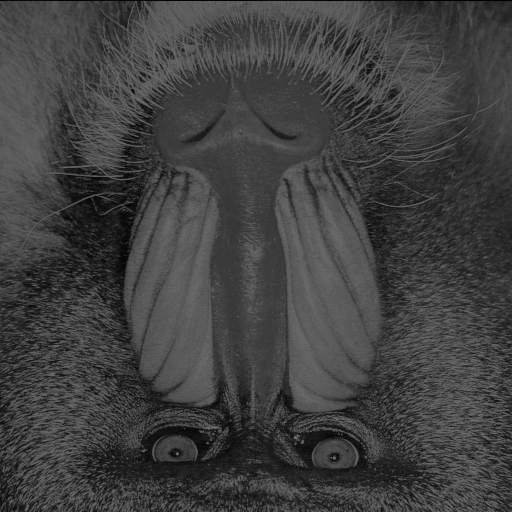

In [4]:
import numpy as np

#lets view our image 
fd = open('/content/BaboonFlipped.raw', 'rb')
rows = 512
cols = 512
f = np.fromfile(fd, dtype=np.uint8,count=rows*cols)
im = f.reshape((rows, cols)) #notice row, column format
fd.close()

from google.colab.patches import cv2_imshow
#display image using cv2_imshow
cv2_imshow(im)